In [2]:
import torch
import random
import scipy
import os
from PIL import Image
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import math
import time
import matplotlib.image
import pprint
import datetime
import torch
import numpy as np
from PIL import Image
from datetime import timedelta
start = time.time()
cuda_opt = True
if torch.cuda.is_available() & cuda_opt:
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
    

In [3]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [4]:

def read_image(file_name):
    image_path = "/mnt/Data/darijani/AdaLISTA/natural_images/"+str(file_name)
    X = (torch.from_numpy(io.imread(image_path)).to(torch.cdouble)).to(DEVICE)/255.0
    return X

def show_image(X):
    image = torch.abs(X)
    image = image/torch.max(image)
    image = image*255.0
    image = image.detach().cpu().numpy().astype(int)
    plt.imshow(image)
    plt.axis('off')
    plt.show()



def save_image(Xhats,N):
    X = torch.abs(Xhats)
    numpy_array = X.detach().cpu().numpy()
    pil_image = Image.fromarray((numpy_array * 255).astype(np.uint8))
    output_path =  "/mnt/Data/darijani/AdaLISTA/natural_images/reconstructed/"
    file_name = 'reconstructed_'+str(N)+'.png'
    pil_image.save(output_path+file_name)

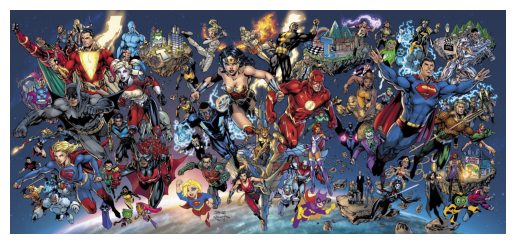

In [5]:
file_name = "dc"
extension = "jpg"
# file_name = input('Enter the Name of The File.')
# extension = input('Enter the Extension of The File.')

path = "/mnt/Data/darijani/AdaLISTA/natural_images/"+str(file_name)+"."+str(extension)
# os.mkdir(file_name)
X = read_image(str(file_name)+"."+str(extension))
show_image(X)
n1, n2 = X.shape[:2]
n_chan = X.shape[2]
L = 21
T_max = 5 
npower_iter = 50                      
tau0 = 330    
# recons_stor_GB = 4                              # max memory you want to assign to save the reconstructed images in GBs
# recons_stor_bits = recons_stor_GB * 1e9 * 8     # max memory you want to assign to save the reconstructed images in bits
# dtype_bits = 128                                # since we are working on complex doubles
# n_recons = min(int(recons_stor_bits/n1/n2/n_chan/dtype_bits),T_max)
# step = int(T_max/n_recons)
# Xhats = torch.zeros(n1,n2,n_chan,n_recons+1,device=DEVICE,dtype=torch.cdouble)
# Xhats[:,:,:,-1] = X
# print(Xhats.shape)
# err = np.zeros((T_max,n_chan))
# X_temp = torch.randn(n1,n2,device=DEVICE,dtype=torch.cdouble)
                          
# def mu(t):
    # return min(1-math.exp(-t/tau0), 0.4)


Masks_1 = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
Masks_2 = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
for ll in range(L):
    Masks_1[:,:,ll] = torch.from_numpy(np.random.choice([1,-1,1j,-1j], (n1,n2), p=[1/4, 1/4, 1/4, 1/4])).to(DEVICE)
    Masks_2[:,:,ll] = torch.from_numpy(np.random.choice([1/math.sqrt(2),math.sqrt(3)], (n1,n2), p=[4/5, 1/5])).to(DEVICE)

Masks = torch.mul(Masks_1,Masks_2)
Unit_Masks = torch.ones(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
# print(n_recons) 
# print(step)

In [6]:
### Make Linear Operators
def A(I,Masks):
    conj = torch.conj_physical(Masks)
    measurements = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
    for ll in range(L):
        measurements[:,:,ll] = torch.fft.fft2(torch.mul(conj[:,:,ll],I))
        
    return measurements

def At(Y,Masks):
    ifft_Y = torch.zeros(n1,n2,L,device=DEVICE,dtype=torch.cdouble) 
    for ll in range(L):
        ifft_Y[:,:,ll] = torch.fft.ifftn(Y[:,:,ll])
    product = torch.mul(Masks , ifft_Y)
    summed = torch.sum(product, dim=2)
    size_y1 = Y.size(0)
    size_y2 = Y.size(1)
    result = summed * size_y1 * size_y2
    
    return result

In [7]:
x_r = torch.squeeze(X[:,:,0])
x_g = torch.squeeze(X[:,:,1])
x_b = torch.squeeze(X[:,:,2])
Y_r = torch.abs(A(x_r,Unit_Masks))**2
Y_g = torch.abs(A(x_g,Unit_Masks))**2
Y_b = torch.abs(A(x_b,Unit_Masks))**2
print(Y_r.shape)
print(torch.linalg.norm(Y_r))

torch.Size([926, 2048, 21])
tensor(2.1239e+12, device='cuda:0', dtype=torch.float64)


In [8]:
print(X.shape)

torch.Size([926, 2048, 3])


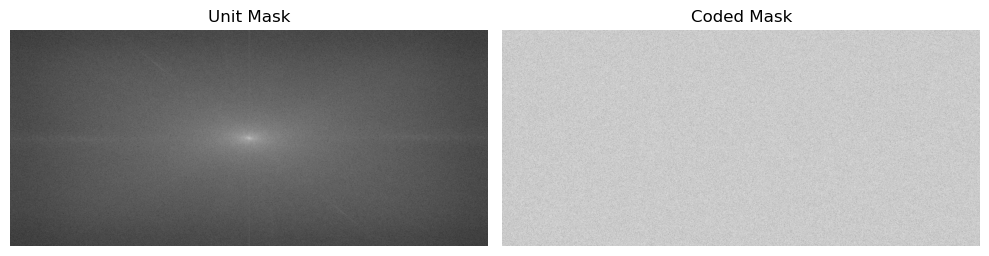

In [9]:

x_r = torch.squeeze(X[:,:,0])
x_g = torch.squeeze(X[:,:,1])
x_b = torch.squeeze(X[:,:,2])
Y_r_unit = A(x_r,Unit_Masks)**2
Y_g_unit = A(x_g,Unit_Masks)**2
Y_b_unit = A(x_b,Unit_Masks)**2
Y_r_coded = A(x_r,Masks)**2
Y_g_coded = A(x_g,Masks)**2
Y_b_coded = A(x_b,Masks)**2
s = random.randint(0,L)
image_unit = torch.log1p(torch.fft.fftshift(Y_r_unit[:,:,s]))
image_coded = torch.log1p(torch.fft.fftshift(Y_r_coded[:,:,s]))
plt.figure(figsize=(10, 5))
image_unit = torch.abs(image_unit)
image_coded = torch.abs(image_coded)
plt.subplot(121)
plt.imshow(image_unit.detach().cpu().numpy(), cmap='gray')
plt.title('Unit Mask')
plt.axis('off')

plt.subplot(122)
# plt.imshow(image_unit.detach().cpu().numpy(), cmap='gray')
plt.imshow(image_coded.detach().cpu().numpy(), cmap='gray')
plt.title('Coded Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
# Save the magnitude spectrum image with high resolution (300 DPI)
output_filename = 'unit_bankai.png'
plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

In [10]:
plt.figure(figsize=(10, 5))
X = torch.abs(X)
image_unit = torch.abs(image_unit)
image_coded = torch.abs(image_coded)
plt.subplot(121)
plt.imshow(image_unit.detach().cpu().numpy(), cmap='gray')
# plt.title('Unit Masks')
plt.axis('off')

plt.subplot(122)
# plt.imshow(image_unit.detach().cpu().numpy(), cmap='gray')
plt.imshow(image_coded.detach().cpu().numpy(), cmap='gray')
# plt.title('Coded Masks')
plt.axis('off')

plt.tight_layout()

output_filename = 'unit vs coded.png'
plt.savefig(output_filename, bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

In [11]:
def Fourier_Visualize(image,name):
    image = torch.log1p(torch.fft.fftshift(image))
    image = torch.abs(image)
    plt.axis('off')
    plt.imshow(image.detach().cpu().numpy(), cmap='gray')
    plt.savefig(name, bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.close()

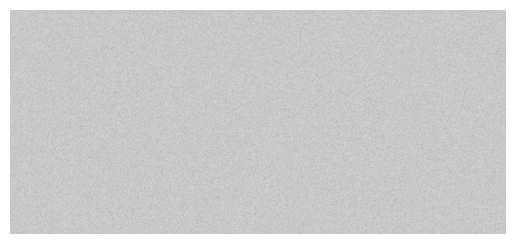

In [12]:
Fourier_Visualize(Y_r_unit[:,:,s],"unit_red")
Fourier_Visualize(Y_g_unit[:,:,s],"unit_green")
Fourier_Visualize(Y_b_unit[:,:,s],"unit_blue")
Fourier_Visualize(Y_r_coded[:,:,s],"coded_red")
Fourier_Visualize(Y_g_coded[:,:,s],"coded_green")
Fourier_Visualize(Y_b_coded[:,:,s],"coded_blue")